In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from ml_model import PipelineManager
from utils.preprocessing_utils import preprocess_notas, merge_classes, word_count_feat_engineering

In [27]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False

## Data setup

In [28]:
df_notas = pd.read_csv('../data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('../data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('../data/sociodemografico.csv', sep=';')

In [29]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [30]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [31]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [32]:
df_notas = preprocess_notas(df_notas)
df_notas = merge_classes(df_notas)
df_notas = word_count_feat_engineering(df_notas)
df_notas.head()

In [ ]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,...,diabet,diet,gluco,insulina,keto,test_reloj_orden,asintoma,preservativo,sable,sifili
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0,0,0,0,0,0,0,0,0,0
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,...,0,1,0,0,0,0,0,0,0,0
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,...,0,1,0,0,0,0,0,0,0,0
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,...,0,1,0,0,0,0,0,0,0,0


## Hyperparameter Setup

In [ ]:
numerical_features = ['Edad'] + list(df_notas.select_dtypes(include='int64').columns)
categorical_features=['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo']
text_features='Plan'

target_feature = 'Código'

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_features(text_features)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    "bootstrap": [True, False],
}
estimator = RandomForestClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta":  np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 100, dtype=float),
    "reg_alpha": np.linspace(0, 10, 100, dtype=float),
    "scale_pos_weight": np.linspace(0.1, 1.5, 5, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

pipeline.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'más',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                               'este',
     

## Label encoding

In [ ]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

y_labels

array([4, 5, 5, ..., 4, 5, 6])

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Hyperparameter tuning

In [ ]:
scoring = {"Accuracy": "balanced_accuracy", "Weighted_F1": make_scorer(f1_score, average='weighted')}
best_model = pipeline.find_best_model(X_train, y_train, cv=5, n_iter=20, n_jobs=-3, scoring=scoring, refit='Weighted_F1')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py

[03:22:10] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strat...
                               gamma=1.0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.0644444451, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0,
                               min_child_weight=10.25, missing=nan,
                               monotone_constraints='()', n_estimators=23,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [ ]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,param_estimator__subsample,...,split0_test_Accuracy,split1_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
2,49.950662,0.604295,4.259527,0.323325,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(sublinear_tf=True),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.55,...,0.257125,0.255459,0.256292,0.000833,1,0.507223,0.499272,0.503247,0.003976,1
0,17.015771,0.067329,6.102973,0.013767,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(),Normalizer(),SimpleImputer(strategy='median'),VarianceThreshold(),0.55,...,0.236987,0.243718,0.240353,0.003366,2,0.487571,0.478693,0.483132,0.004439,2
1,12.566098,0.099854,4.124902,0.075462,"CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(sublinear_tf=True),StandardScaler(),SimpleImputer(strategy='median'),SelectFromModel(estimator=ElasticNet()),0.1,...,0.216142,0.217973,0.217058,0.000915,3,0.397238,0.385592,0.391415,0.005823,3
3,8.773189,0.032540,0.000000,0.000000,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(norm='l1'),Normalizer(),SimpleImputer(strategy='median'),SelectFromModel(estimator=Lasso()),0.1,...,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,4


## Scoring

In [ ]:
score = pipeline.score(X_test, y_test)
score

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,0.751855,0.574685,0.263184,0.574685,0.267052,0.514902,"[[0, 0, 2922, 20, 0, 6, 0], [0, 0, 1521, 55, 0...","[[0.0, 0.0, 0.026057179546630047, 0.0001783516...",precision recall f1-score ...


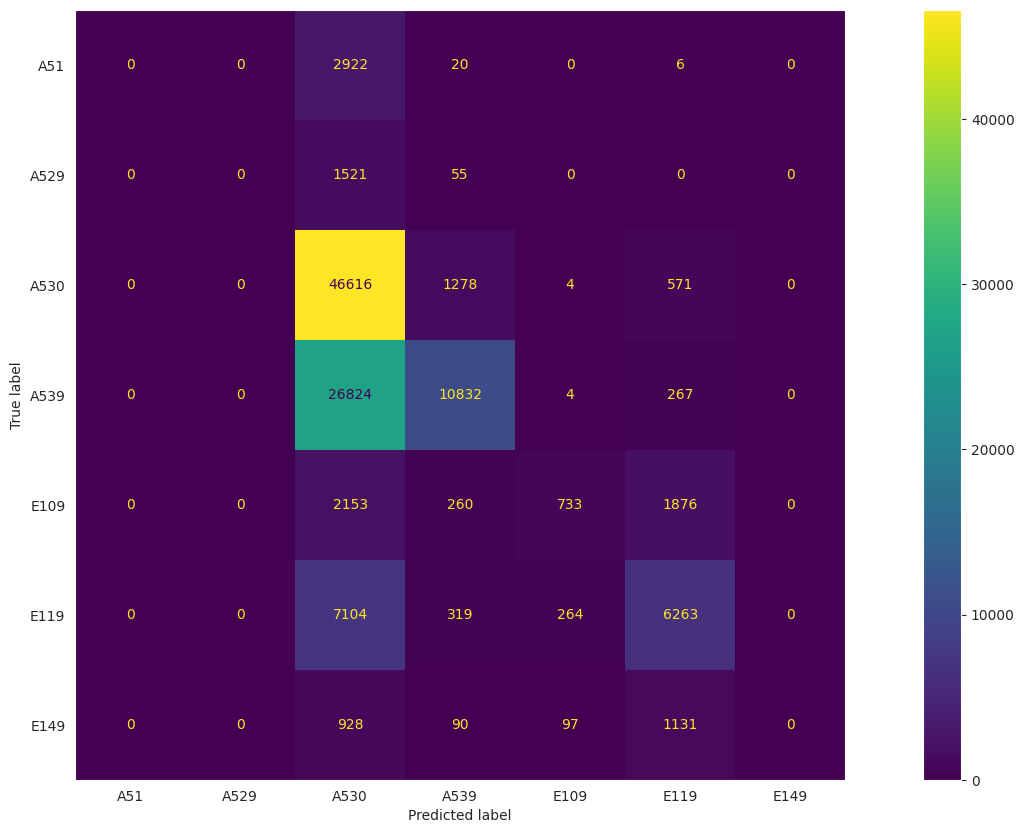

In [ ]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

In [ ]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A51,0.00,0.00,0.00,2948.00
A529,0.00,0.00,0.00,1576.00
A530,0.53,0.96,0.68,48469.00
A539,0.84,0.29,0.43,37927.00
E109,0.67,0.15,0.24,5022.00
E119,0.62,0.45,0.52,13950.00
E149,0.00,0.00,0.00,2246.00
accuracy,0.57,0.57,0.57,0.57
macro avg,0.38,0.26,0.27,112138.00
weighted avg,0.62,0.57,0.51,112138.00
